### Tuning hyper-paremter of BG cell classifier

In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/')

from constants import * 
from base import *
from custom_metrics import *
from tuning_cv import *

In [2]:
## Importing libraries 
import pandas as pd
import numpy as np 
import random 

from sklearn import preprocessing 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

### Importing data 

In [3]:
# Annotated cells 
cell_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/BG/cells/"
cell_training = "training.txt"

# NNB information of all cells on slide
nnb_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/BG/NNB/"
nnb_training = "training_NNB.txt"

# hema nucleus of all cells on slide
hema_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/BG/hema/"
hema_training = "training_hema.txt"

Require: 
1. input_files.txt - to contian filenames I want to use. ** currently .csv files

In [4]:
# Importing annotated cells 

# obtaining list of files 
with open(cell_path + cell_training) as f: 
    mylist= f.read().splitlines()
    
print("Read in: ",len(mylist),"files")

# reading in all those files 
inputs = [] 
for i in mylist: 
    dat_ = pd.read_csv(cell_path + i,sep=",")
    dat_.columns.values[5] = 'Centroid_X'
    dat_.columns.values[6] = 'Centroid_Y'
    dat = dat_[cell_extracted_features] # fixed extracted feature order
    inputs.append(dat)
print("Extracted:", len(inputs),"files")


Read in:  20 files
Extracted: 20 files


In [5]:
# Importing in neghbouring cells info (numbers)

# with open(nnb_path + nnb_training) as f: 
#     nb_mylist= f.read().splitlines()
    
# print("Read in:",len(nb_mylist)," NUMBER OF neighbouring cells files")
nb_mylist = [i[0:6]+'_all_neighbours.csv' for i in mylist]
print("Read in:",len(nb_mylist)," NUMBER OF neighbouring cells files")

# reading in all those files 
nb_inputs = []
nb_columns = [] 
for i in nb_mylist: 
    dat = pd.read_csv(nnb_path +i,sep=",")
    dat.columns.values[0] = 'X'
    dat.columns.values[1] = 'Y'
    nb_inputs.append(dat)
    nb_columns.append(dat.shape[1])
    
print("Extracted:", len(nb_inputs),"files")
print('no. of columns / NB file:', nb_columns)

Read in: 20  NUMBER OF neighbouring cells files


Extracted: 20 files
no. of columns / NB file: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 13, 13]


In [6]:
#  Importing hema nucleus mean of all detected cells & location coordinates 
# Variables: hema_mylist, hema_inputs 

## obtaining list of files 
# with open(hema_path + hema_training) as f: 
#     hema_mylist= f.read().splitlines()
    
# print("Read in:",len(hema_mylist),"hema files")
hema_mylist = [i[0:6]+'_hema.csv' for i in mylist]    
print("Read in:",len(hema_mylist),"hema files")   


## 4) reading in all those files 
hema_inputs = [] 
for i in hema_mylist: 
    dat = pd.read_csv(hema_path + i,sep=",")
    dat.columns.values[0] = 'Centroid_X' # To fix naming inconsistency problem 
    dat.columns.values[1] = 'Centroid_Y'
    hema_inputs.append(dat)

print("Extracted:",len(hema_inputs),"hema files")  


Read in: 20 hema files
Extracted: 20 hema files


In [7]:
# Checking if filenames & order of them from mylist, nb_mylist & hema_mylist match
x_nb = [i[0:6] for i in nb_mylist]
x = [i[0:6] for i in mylist]
x_h = [i[0:6] for i in hema_mylist]
print("mylist & nb_list matched?:", x==x_nb)
print("mylist & hema_list matched?:",x==x_h)

mylist & nb_list matched?: True
mylist & hema_list matched?: True


In [8]:
# combine cells with NNB information
inputs_with_nbb, output_log = combine_annotated_to_NNB2(annotated_list = inputs,
                                                        NNB_list = nb_inputs)
print(output_log)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [9]:
nb_inputs[0].columns

Index(['X', 'Y', 'NN_10_um', 'NN_20_um', 'NN_30_um', 'NN_40_um', 'NN_50_um',
       'NN_60_um', 'NN_70_um', 'NN_80_um', 'NN_90_um', 'NN_100_um',
       'NN_110_um', 'NN_120_um', 'NN_130_um', 'NN_140_um', 'NN_150_um',
       'slice_id'],
      dtype='object')

In [10]:
# Find cells to remove based on hematoxylin staining (from normalisation, remove top 1%)
hema_to_remove = find_hema_to_remove(hema_inputs)

# for i in range(0,len(hema_to_remove)): 
#     print(i, " No. of cells with normalised Hema >1:",len(hema_to_remove[i]), "from", len(hema_inputs[i]),"detected cells")

In [11]:
# remove cells that have hema above criteria
cleaned_inputs, remove_log = remove_cell_hema(inputs_with_nbb,
                                              hema_to_remove)
print(remove_log)
print(cleaned_inputs[0].shape)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
(89, 56)


### Putting the slides together 

In [12]:
##Variables: labelled_orig, labelled_data 
#1) Put the slides together

labelled_orig = pd.concat(cleaned_inputs)
print(labelled_orig.shape)

# 2) Extract relevant columns 
dat = labelled_orig.drop(columns=['Name','Parent','ROI', 'NN_110_um', 'NN_120_um', 'NN_130_um', 'NN_140_um', 'NN_150_um']) 
dat.head()


(1694, 56)


,Image,Class,Centroid_X,Centroid_Y,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,721708.svs,Oligo,12022.2,8715.8,0.8575,13.1628,13.2907,0.9364,1.0,4.9150,...,1,1,2,7,10,15,22,30,37,50
1,721708.svs,Oligo,12029.8,8722.0,0.8796,15.2611,14.0081,0.9773,1.0,4.7992,...,1,1,1,4,10,17,24,34,38,49
2,721708.svs,Oligo,10048.5,9974.4,0.8670,16.7321,14.7662,0.9643,1.0,5.0758,...,1,3,5,7,11,14,25,35,52,65
3,721708.svs,Oligo,10029.8,9984.5,0.8827,18.6383,15.5263,0.9716,1.0,5.3159,...,1,1,4,6,9,17,26,36,47,63
4,721708.svs,Oligo,10031.0,9993.5,0.8682,21.4955,16.7517,0.9626,1.0,5.7030,...,1,1,4,6,11,18,24,35,49,64


### Extracting relevant cell classes

In [13]:
# Make all class names lower case - easier for later selection

dat_lower_class = [i.lower() for i in dat['Class']]
dat2 = dat.copy()
dat2.loc[:,'Class'] = dat_lower_class 
dat2['Class'].value_counts()

oligo              783
endo               289
neuron             200
astro              187
ignore             142
epi                 28
fragmented          27
ambiguous           22
tuftedastrocyte     13
tumor                2
neuronaltau          1
Name: Class, dtype: int64

In [14]:
# Select only relevant cell classes (Using stardist_error instead of ignore_new)
dat3 = dat2[(dat2['Class'] == 'oligo') | (dat2['Class'] == 'neuron')
          | (dat2['Class'] == 'astro')| (dat2['Class'] == 'epithelial')
          | (dat2['Class'] == 'ignore')| (dat2['Class'] == 'fragmented')| (dat2['Class'] == 'endo')]
dat3=dat3.reset_index(drop=True)

# Checking results
dat3['Class'].value_counts()

oligo         783
endo          289
neuron        200
astro         187
ignore        142
fragmented     27
Name: Class, dtype: int64

In [15]:
cell_code = {'neuron':'Neuron',
             'oligo': 'Oligo',
             'ignore': 'Others',
             'astro':'Astro',
             'epithelial':'Others',
             'endo':'Others',
             'fragmented':'Others'}

In [16]:
# 3) Changing Epithelial to Endothelial
classes = dat3['Class']
formatted_classes = [cell_code[i]  for i in classes]
data = dat3.copy()
data.loc[:,'Class']=formatted_classes

In [17]:

data['Class'].value_counts()

Oligo     783
Others    458
Neuron    200
Astro     187
Name: Class, dtype: int64

In [18]:
# Export cleaned data out for easy use: 
# path = '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Cell_classification/bg_training_data.txt'
# data.to_csv(path, sep="\t", index=False)

# Training the model

### Checking for any NA in the data

In [19]:
#checking for NAN 
## NEW 
print("Any NA in the data?: ",data.isnull().sum().sum()==1)

#dat = dat.dropna()
#dat.isnull().sum().sum()

Any NA in the data?:  False


### Create train, test sets 

In [20]:
#We are using the entire dataset to train the model, test data will be provided later by Sanne 
X_train_l = data.drop(columns=['Class'])
X_train = X_train_l.drop(columns=['Image','Centroid_X','Centroid_Y'])
print('training data shape:',X_train.shape)
y_train = data['Class']

training data shape: (1628, 44)


In [21]:
X_train.head()

,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,Nucleus: Min diameter µm,Cell: Area µm^2,Cell: Length µm,Cell: Circularity,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,0.8575,13.1628,13.2907,0.9364,1.0,4.9150,3.4944,103.1323,37.8404,0.9051,...,1,1,2,7,10,15,22,30,37,50
1,0.8796,15.2611,14.0081,0.9773,1.0,4.7992,4.1628,120.9785,40.6755,0.9189,...,1,1,1,4,10,17,24,34,38,49
2,0.8670,16.7321,14.7662,0.9643,1.0,5.0758,4.3099,100.9326,38.6687,0.8482,...,1,3,5,7,11,14,25,35,52,65
3,0.8827,18.6383,15.5263,0.9716,1.0,5.3159,4.4388,124.4651,42.9339,0.8485,...,1,1,4,6,9,17,26,36,47,63
4,0.8682,21.4955,16.7517,0.9626,1.0,5.7030,5.0028,136.2816,44.2523,0.8745,...,1,1,4,6,11,18,24,35,49,64


In [69]:
pipeline_cell

Pipeline(steps=[('normalizer', MinMaxScaler()),
                ('selector',
                 RFE(estimator=RandomForestClassifier(random_state=42))),
                ('clf', BalancedRandomForestClassifier())])

### Hyperparameter tuning - random forest

In [71]:
# Create the random grid 

rf_random = RandomizedSearchCV(pipeline_cell,
                             param_distributions=random_grid, 
                             n_iter=100,
                             cv=10,
                             verbose=2,
                            random_state=42,
                            n_jobs=-1,
                              refit='PR_AUC', # use this metric to evaluate performance of parameters 
                      scoring={'PR_AUC':precision_recall_auc,
                          'roc_auc_ovr_weighted':'roc_auc_ovr_weighted',
                            'roc_auc_ovo':'roc_auc_ovo',
                              'balanced_accuracy':'balanced_accuracy',
                               'f1_weighted':'f1_weighted',
                               'Astro_accuracy': astro_acc,
                               'Neuron_accuracy':neuron_acc,
                               'Oligo_accuracy':oligo_acc,
                               'Others_accuracy':others_acc,
                               'A_as_N':A_as_N,
                               'A_as_O':A_as_O,
                               'A_as_Others':A_as_Others,
                               'N_as_A':N_as_A,
                               'N_as_O':N_as_O,
                               'N_as_Others':N_as_Others,
                               'O_as_A':O_as_A,
                               'O_as_N':O_as_N,
                               'O_as_Others':O_as_Others,
                               'Others_as_A':Others_as_A,
                               'Others_as_N':Others_as_N,
                               'Others_as_O':Others_as_O
                              })

rf_random.fit(X_train,y_train)

print(rf_random.best_score_)
print(rf_random.best_params_)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
0.8472707312197695
{'selector__n_features_to_select': 38, 'clf__sampling_strategy': 'not majority', 'clf__random_state': 42, 'clf__n_estimators': 600, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_samples': 0.75, 'clf__max_features': 0.2, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'}


In [72]:
# # Digging into more details 
print("PR-AUC:",
     rf_random.cv_results_['mean_test_PR_AUC'][rf_random.best_index_]*100)
print("ROC-AUC:",
     rf_random.cv_results_['mean_test_roc_auc_ovr_weighted'][rf_random.best_index_]*100)
print("ROC-AUC:",
     rf_random.cv_results_['mean_test_roc_auc_ovo'][rf_random.best_index_]*100)

print("Balanced accuracy:",
      rf_random.cv_results_['mean_test_balanced_accuracy'][rf_random.best_index_]*100)

print("F1_weighted:",
      rf_random.cv_results_['mean_test_f1_weighted'][rf_random.best_index_]*100)

print("Astrocyte accuracy:",
      rf_random.cv_results_['mean_test_Astro_accuracy'][rf_random.best_index_]*100)

print("Neuron accuracy:",
      rf_random.cv_results_['mean_test_Neuron_accuracy'][rf_random.best_index_]*100)

print("Oligo accuracy:",
      rf_random.cv_results_['mean_test_Oligo_accuracy'][rf_random.best_index_]*100)

print("Others accuracy:",
      rf_random.cv_results_['mean_test_Others_accuracy'][rf_random.best_index_]*100)


print("Classified A as N:",
      rf_random.cv_results_['mean_test_A_as_N'][rf_random.best_index_]*100)

print("Classified A as O:",
      rf_random.cv_results_['mean_test_A_as_O'][rf_random.best_index_]*100)

print("Classified A as Others:",
      rf_random.cv_results_['mean_test_A_as_Others'][rf_random.best_index_]*100)

print("Classified N as A:",
      rf_random.cv_results_['mean_test_N_as_A'][rf_random.best_index_]*100)

print("Classified N as O:",
      rf_random.cv_results_['mean_test_N_as_O'][rf_random.best_index_]*100)

print("Classified N as Others:",
      rf_random.cv_results_['mean_test_N_as_Others'][rf_random.best_index_]*100)

print("Classified O as A:",
      rf_random.cv_results_['mean_test_O_as_A'][rf_random.best_index_]*100)

print("Classified O as N:",
      rf_random.cv_results_['mean_test_O_as_N'][rf_random.best_index_]*100)

print("Classified O as Others:",
      rf_random.cv_results_['mean_test_O_as_Others'][rf_random.best_index_]*100)


print("Classified Others as A:",
      rf_random.cv_results_['mean_test_Others_as_A'][rf_random.best_index_]*100)

print("Classified Others as N:",
      rf_random.cv_results_['mean_test_Others_as_N'][rf_random.best_index_]*100)

print("Classified Others as O:",
      rf_random.cv_results_['mean_test_Others_as_O'][rf_random.best_index_]*100)
                                                       

PR-AUC: 84.72707312197694
ROC-AUC: 95.42289392156897
ROC-AUC: 94.26802402662095
Balanced accuracy: 76.89923610321968
F1_weighted: 80.25597122911175
Astrocyte accuracy: 69.61988304093568
Neuron accuracy: 82.5
Oligo accuracy: 91.30314832846477
Others accuracy: 64.17391304347827
Classified A as N: 15.46783625730994
Classified A as O: 9.005847953216374
Classified A as Others: 5.906432748538011
Classified N as A: 14.499999999999998
Classified N as O: 0.5
Classified N as Others: 2.5
Classified O as A: 4.607270366764038
Classified O as N: 0.25478740668614086
Classified O as Others: 3.834793898085037
Classified Others as A: 12.657004830917876
Classified Others as N: 6.97584541062802
Classified Others as O: 16.193236714975846


PR-AUC: 84.72707312197694
ROC-AUC: 95.42289392156897
ROC-AUC: 94.26802402662095
Balanced accuracy: 76.89923610321968
F1_weighted: 80.25597122911175
Astrocyte accuracy: 69.61988304093568
Neuron accuracy: 82.5
Oligo accuracy: 91.30314832846477
Others accuracy: 64.17391304347827
Classified A as N: 15.46783625730994
Classified A as O: 9.005847953216374
Classified A as Others: 5.906432748538011
Classified N as A: 14.499999999999998
Classified N as O: 0.5
Classified N as Others: 2.5
Classified O as A: 4.607270366764038
Classified O as N: 0.25478740668614086
Classified O as Others: 3.834793898085037
Classified Others as A: 12.657004830917876
Classified Others as N: 6.97584541062802
Classified Others as O: 16.193236714975846

In [73]:
# save object using joblib
joblib.dump(rf_random, 'BG_random_search.sav')

['BG_random_search.sav']

## Manual cross validation, using PR curves

{'selector__n_features_to_select': 38, 'clf__sampling_strategy': 'not majority', 'clf__random_state': 42, 'clf__n_estimators': 600, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_samples': 0.75, 'clf__max_features': 0.2, 'clf__max_depth': 10, 'clf__class_weight': 'balanced'}


In [120]:
bg_classifier_hyperparams = [
    ('normalizer', MinMaxScaler()),
    ('selector', RFE(estimator=RandomForestClassifier(random_state=42),
        n_features_to_select=38)),
    ('clf', BalancedRandomForestClassifier(
        random_state=42,
        sampling_strategy='not majority',
        n_estimators=600,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features=0.2,
        max_depth=10,
        max_samples=0.75,
        class_weight='balanced'))]
        
# 10-fold cross validation
model = ClassifierTuning(hyperparameters=bg_classifier_hyperparams)
model.find_bestparameters(X=X_train,
                          Y=y_train)

In [78]:
model.best_parameters

{0: (0.4592835374462488,
  0.6815173626938333,
  0.6891846826044234,
  0.7271929824561404),
 1: (0.48042408021969285, 0.8543324993612236, 0.8301907662241488, 0.89),
 2: (0.5122155925759821,
  0.917856339157616,
  0.9174491900312752,
  0.9206913339824732),
 3: (0.2164000689682492,
  0.8331716197778333,
  0.8025224539600778,
  0.87512077294686)}

In [79]:
model.cv_withthresholding(best_parameters=model.best_parameters,
                          X=X_train,
                          Y=y_train,
                          X_location = X_train_l)

In [80]:
# Confusion matrix across 10 folds, WITH thresholding 
print('with thresholding (non-calibrated) ACC :', mean(model.cv_accuraciesT)*100)
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reportsT])*100)
print("--------------------------")
cf_t = sum(model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100
print(cf_t)
print(final_cm_t)
print("--------------------------")
print("Astro accuracy",final_cm_t[0][0])
print("Neuron accuracy",final_cm_t[1][1])
print("Oligo accuracy",final_cm_t[2][2])
print("Oligo accuracy",final_cm_t[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reportsT])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reportsT])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reportsT])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reportsT])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reportsT])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reportsT])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reportsT])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reportsT])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

with thresholding (non-calibrated) ACC : 80.67389835962358
Macro avg F1  80.24022775035937
Weighted avg F1  85.11553081544446
--------------------------
[[119  26   9  21]
 [ 21 157   1  13]
 [ 25   0 679  42]
 [ 24  13  33 336]]
[[68.         14.85714286  5.14285714 12.        ]
 [10.9375     81.77083333  0.52083333  6.77083333]
 [ 3.35120643  0.         91.01876676  5.63002681]
 [ 5.91133005  3.20197044  8.12807882 82.75862069]]
--------------------------
Astro accuracy 68.0
Neuron accuracy 81.77083333333334
Oligo accuracy 91.01876675603218
Oligo accuracy 82.75862068965517
------------------------------
Astro f1-score  66.46933345143063
Astro precision  65.71668268033166
Astro recall  67.9327915376677
--------------------------
Neuron f1-score  80.17320063655148
Neuron precision  81.82284664229743
Neuron recall  81.27192982456141
--------------------------
Oligo f1-score  92.38149624941695
Oligo precision  94.26507912872677
Oligo recall  90.87827585776395
--------------------------
O

In [81]:
model.cv_nothresholding(X=X_train,
                        Y=y_train,
                        X_location= X_train_l)

In [82]:
#Confusion matrix across 10 folds, WITHOUT thresholding 
print('with no thresholding:',
      mean(model.cv_accuracies)*100)
print('Macro avg F1 ',
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reports])*100)
print("--------------------------")
cf = sum(model.cv_confusion_matrices)
final_cm =  cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]*100
print(cf)
print(final_cm)
print("--------------------------")
print("Astro accuracy",final_cm[0][0])
print("Neuron accuracy",final_cm[1][1])
print("Oligo accuracy",final_cm[2][2])
print("Others accuracy",final_cm[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reports])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reports])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reports])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reports])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reports])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reports])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Others f1-score ',mean([i['Others']['f1-score'] for i in model.cv_reports])*100)
print('Others precision ',mean([i['Others']['precision'] for i in model.cv_reports])*100)
print('Others recall ',mean([i['Others']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)

with no thresholding: 76.89923610321968
Macro avg F1  75.12875370023431
Weighted avg F1  80.25597122911176
--------------------------
[[130  29  17  11]
 [ 29 165   1   5]
 [ 36   2 715  30]
 [ 58  32  74 294]]
[[69.51871658 15.50802139  9.09090909  5.88235294]
 [14.5        82.5         0.5         2.5       ]
 [ 4.59770115  0.25542784 91.31545338  3.83141762]
 [12.66375546  6.98689956 16.15720524 64.19213974]]
--------------------------
Astro accuracy 69.5187165775401
Neuron accuracy 82.5
Oligo accuracy 91.3154533844189
Others accuracy 64.19213973799127
------------------------------
Astro f1-score  60.24792478239205
Astro precision  53.60245741318914
Astro recall  69.61988304093568
--------------------------
Neuron f1-score  76.94336824851294
Neuron precision  73.93239329108894
Neuron recall  82.5
--------------------------
Oligo f1-score  89.90102332272
Oligo precision  88.79785220128038
Oligo recall  91.30314832846479
--------------------------
Others f1-score  73.42269844731231
O

In [83]:
# save object using joblib
joblib.dump(model, 'bg_cv_results.sav')

['bg_cv_results.sav']

Train the final model

In [121]:
bg_classifier_hyperparams

[('normalizer', MinMaxScaler()),
 ('selector',
  RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=38)),
 ('clf',
  BalancedRandomForestClassifier(class_weight='balanced', max_depth=10,
                                 max_features=0.2, max_samples=0.75,
                                 min_samples_leaf=2, min_samples_split=5,
                                 n_estimators=600, random_state=42,
                                 sampling_strategy='not majority'))]

In [122]:
# Train final model
bg_model = Pipeline(bg_classifier_hyperparams)
final_model = bg_model.fit(X_train,y_train)

In [123]:
joblib.dump(final_model, 'bg_cell_classifier.sav')

['bg_cell_classifier.sav']

Extracting information

In [23]:
# The final model
loaded_model = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Results/bg_cv_results.sav')
cf_t = sum(loaded_model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100

In [24]:
# find out proportion of ambiguous cells 
predicted = (sum(loaded_model.cv_y_predictsT, []))
print('total:',len(predicted))
print(set(predicted))
amb_n = sum(1 for i in predicted if i =='Ambiguous')
print('Ambiguous: ',amb_n)
print('proportion Ambiguous: ', amb_n/len(predicted) )

total: 1628
{'Neuron', 'Astro', 'Others', 'Ambiguous', 'Oligo'}
Ambiguous:  109
proportion Ambiguous:  0.06695331695331695


In [25]:
final_cm_t

array([[68.        , 14.85714286,  5.14285714, 12.        ],
       [10.9375    , 81.77083333,  0.52083333,  6.77083333],
       [ 3.35120643,  0.        , 91.01876676,  5.63002681],
       [ 5.91133005,  3.20197044,  8.12807882, 82.75862069]])

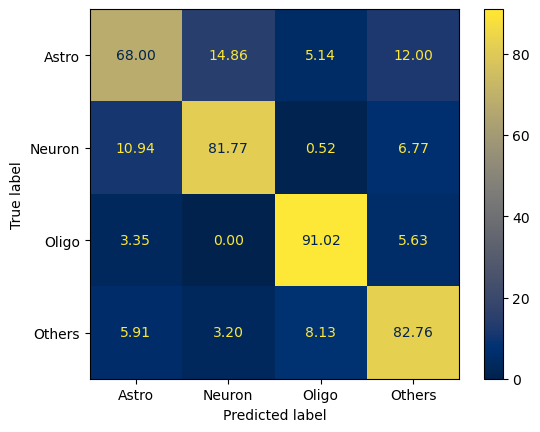

In [26]:
plot = ConfusionMatrixDisplay(final_cm_t,
                              display_labels=['Astro', 'Neuron', 'Oligo', 'Others'])
plot.plot(cmap='cividis', values_format='.2f')         
plt.show()

In [27]:
model = loaded_model
# Confusion matrix across 10 folds, WITH thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

Macro avg F1  80.24022775035937
Macro avg F1 std  5.05567606848565
--------------------------
Macro avg precision 80.87885155718585
Macro avg precision std 5.073427461759179
--------------------------
Macro avg recall  80.67389835962358
Macro avg recall std 5.20286447595862


In [28]:
model = loaded_model
# Confusion matrix across 10 folds, WITH NO thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reports])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reports])*100)

Macro avg F1  75.12875370023431
Macro avg F1 std  5.745827609247249
--------------------------
Macro avg precision 75.67981300828515
Macro avg precision std 5.3612409813143
--------------------------
Macro avg recall  76.89923610321968
Macro avg recall std 5.900731217269755


Plotting feature importance

In [29]:
import seaborn as sns

In [30]:
model_rf = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Results/bg_random_search.sav')

In [31]:
model_rf.best_params_

{'selector__n_features_to_select': 38,
 'clf__sampling_strategy': 'not majority',
 'clf__random_state': 42,
 'clf__n_estimators': 600,
 'clf__min_samples_split': 5,
 'clf__min_samples_leaf': 2,
 'clf__max_samples': 0.75,
 'clf__max_features': 0.2,
 'clf__max_depth': 10,
 'clf__class_weight': 'balanced'}

In [32]:
#With feature selection
rf_result = model_rf.best_estimator_.named_steps['selector'].get_support(indices=True)
rf_result
rf_result_f = [X_train.columns[i] for i in rf_result]
# (rf_result_f)
importance = model_rf.best_estimator_.named_steps['clf'].feature_importances_
f_importance = pd.DataFrame(data={'features':rf_result_f,'importance':importance})
f_importance = f_importance.sort_values(by=['importance'],ascending=False)

In [33]:
f_importance_subset = f_importance[0:11]
features = [i.replace('ROI: 0.25 µm per pixel: ','') for i in f_importance_subset['features']]
f_importance_subset = f_importance_subset.copy()
f_importance_subset.loc[:,'features'] = features
f_importance_subset = f_importance_subset.rename(columns={'features':'Feature',
                                    'importance':'Importance'})

In [34]:
f_importance_subset

,Feature,Importance
1,Nucleus: Area µm^2,0.123232
2,Nucleus: Length µm,0.110194
5,Nucleus: Max diameter µm,0.100658
6,Nucleus: Min diameter µm,0.077623
11,Cell: Max diameter µm,0.072434
8,Cell: Length µm,0.050932
0,Detection probability,0.045960
15,Hematoxylin: Nucleus: Median,0.037469
3,Nucleus: Circularity,0.036762
14,Hematoxylin: Nucleus: Mean,0.036711


<Axes: xlabel='Importance', ylabel='Feature'>

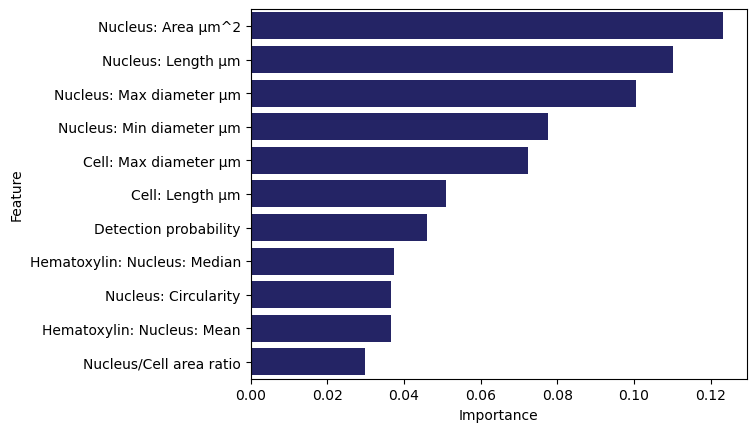

In [35]:
sns.barplot(data=f_importance_subset,
            y="Feature",
            x="Importance",
            color='midnightblue')

In [36]:
keys = ['split0_test_PR_AUC',
        'split1_test_PR_AUC',
        'split2_test_PR_AUC',
        'split3_test_PR_AUC',
        'split4_test_PR_AUC',
        'split5_test_PR_AUC',
        'split6_test_PR_AUC',
        'split7_test_PR_AUC',
        'split8_test_PR_AUC',
        'split9_test_PR_AUC']
pr_val = []
for i in keys:
    pr_val.append(model_rf.cv_results_[i][model_rf.best_index_])

In [37]:
print(model_rf.cv_results_['mean_test_PR_AUC'][model_rf.best_index_]*100)
print('mean pr:', mean(pr_val)*100)
print('std pr:', np.std(pr_val)*100)

84.72707312197694
mean pr: 84.72707312197696
std pr: 6.311638799332325
